<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Проект 12. Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('taxi.csv')

Количество дубликатов: 0


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


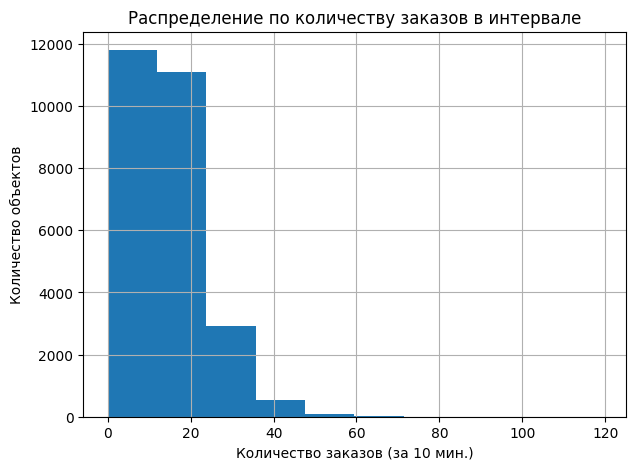

In [3]:
# функция вызывающая все методы для обзора данных
def data_review(data):
    print('Количество дубликатов:', data.duplicated().sum())
    display(data.head(10))
    display(data.info())
    display(data.describe())
    data.hist(figsize=(7, 5))
    plt.title('Распределение по количеству заказов в интервале')
    plt.xlabel('Количество заказов (за 10 мин.)')
    plt.ylabel('Количество объектов')
    plt.show()
    
# вызовем функцию, чтобы вывести информацию о датафрейме под номером 0
data_review(data)

Исходные данные уже неплохого качества, но для дальнейшего анализа их необходимо подготовить.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
data.set_index('datetime', inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

Выполним ресемплирование по часу.

In [8]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Добавим функцию для создания новых признаков. Это поможет модели лучше понять существующие закономерности.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek   
    df['hour'] = df.index.hour
    #добавим в качестве признаков предыдущие значеия временного ряда
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag) 
    #добавим в качестве признака скользящее среднее временного ряда
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()  
    df = df.dropna()
    return df

Добавим овые признаки в датафрейм.

In [10]:
new_data = make_features(data, 24, 12)
new_data.head()

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333
2018-03-02 01:00:00,120,3,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.583333
2018-03-02 02:00:00,75,3,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,68.916667
2018-03-02 03:00:00,64,3,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.166667
2018-03-02 04:00:00,20,3,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.000000


Если в дальнейшем при обучении моделей значения *RMSE* будут слишком низкие, то имеет смысл вернуться к данной функции и попробовать перебор разных аргументов функции создания новых признаков.

**Вывод**

В данном разделе мы:
- загрузили и изучили данные,
- подготовили данные к анализу,
- создали функцию для добавления новых признаков.

Данные подготовлены и теперь мы можем переходить к анализу.

## Анализ

Построим графики для анализа временного ряда. Добавим скользящее среднее, оценим возможные тренды и сезонность.

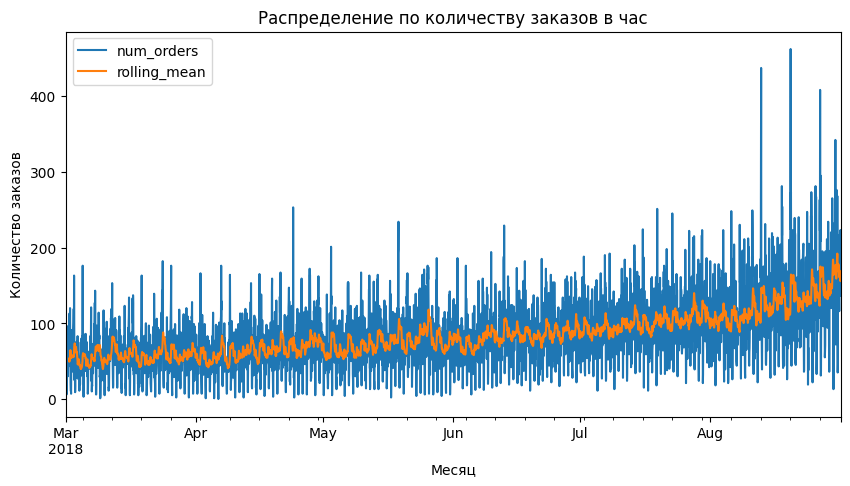

In [12]:
data['rolling_mean'] = data.rolling(20).mean()
data.plot(figsize=(10, 5))
plt.title('Распределение по количеству заказов в час')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()    

Такой график оценивать сложно, ресемплируем данные по одному дню.

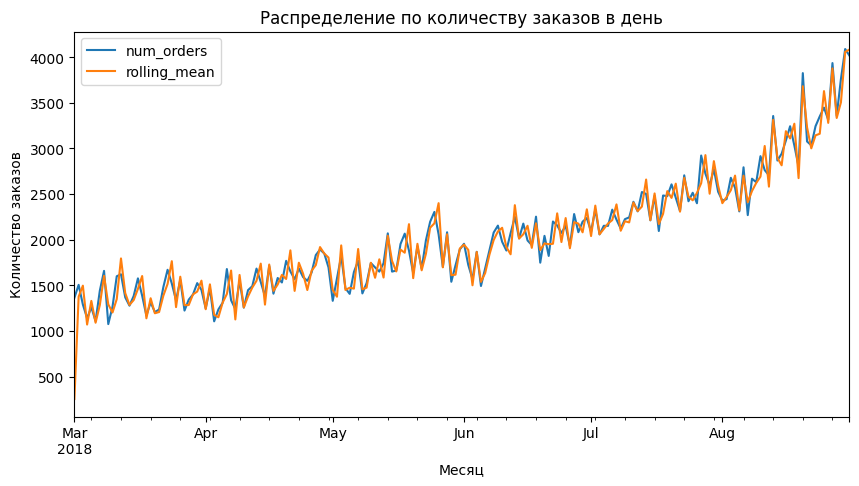

In [13]:
data.resample('1D').sum().plot(figsize=(10, 5))
plt.title('Распределение по количеству заказов в день')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()    

Такой график все еще недостаточо информативен. Пока лишь можно сказать, что суммарное количество поездок за день летом стремительно возрастает. Декомпозируем данные и построим графк тренда.

In [14]:
data = data.drop('rolling_mean', errors='ignore', axis=1)

In [15]:
decomposed_data = seasonal_decompose(data.resample('1D').sum())

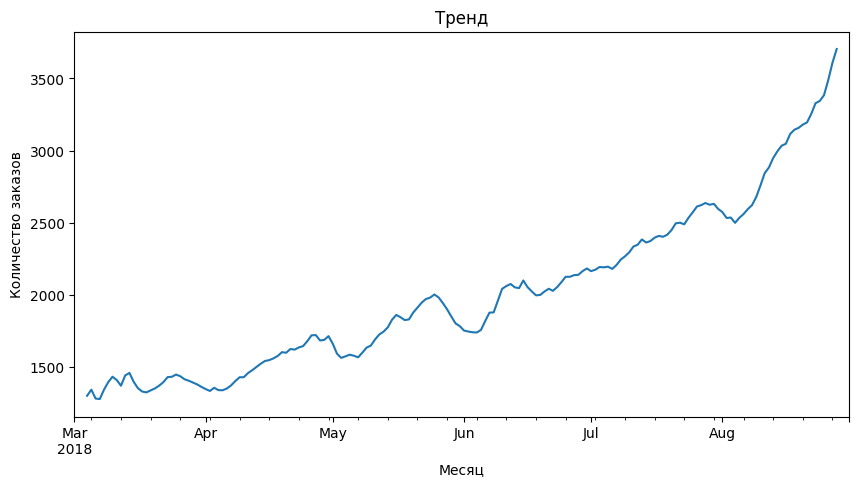

In [16]:
plt.figure(figsize=(10, 5))
decomposed_data.trend.plot(title='Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Наши подозрения подтвердились. С марта суммарное количество ежедневных заказов росло со временем.

Посмотрим на сезонность в данных. Оценим выборку целиком.

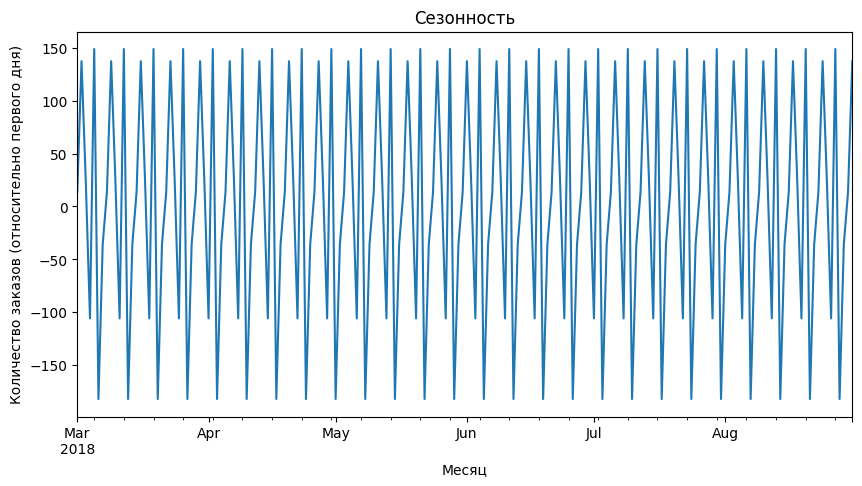

In [17]:
plt.figure(figsize=(10, 5))
decomposed_data.seasonal.plot(title='Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

В целом, можно заметить, что в данных присутсвует некоторая сезонность, однако для того, чтобы понять какая именно, необходимо рассмотреть ряд на меньшем временном отрезке.

Оценим первые две недели марта.

In [18]:
data.resample('1D').sum()['2018-03-01':'2018-03-15'].index.dayofweek

Int64Index([3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3], dtype='int64', name='datetime')

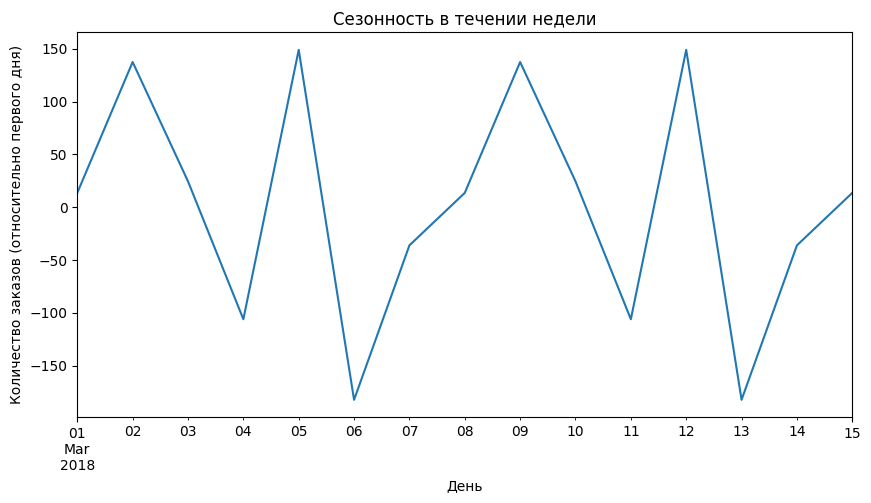

In [19]:
plt.figure(figsize=(10, 5))
decomposed_data.seasonal['2018-03-01':'2018-03-15'].plot(title='Сезонность в течении недели')
plt.xlabel('День')
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

Судя по графику, наибольшее количество поездок приходится на понедельник и пятницу. Во вторник и в выходные дни количество поездок снижается. 

Посмотрим на аналогичные данные в июле.

In [20]:
data.resample('1D').sum()['2018-07-01':'2018-07-15'].index.dayofweek

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6], dtype='int64', name='datetime')

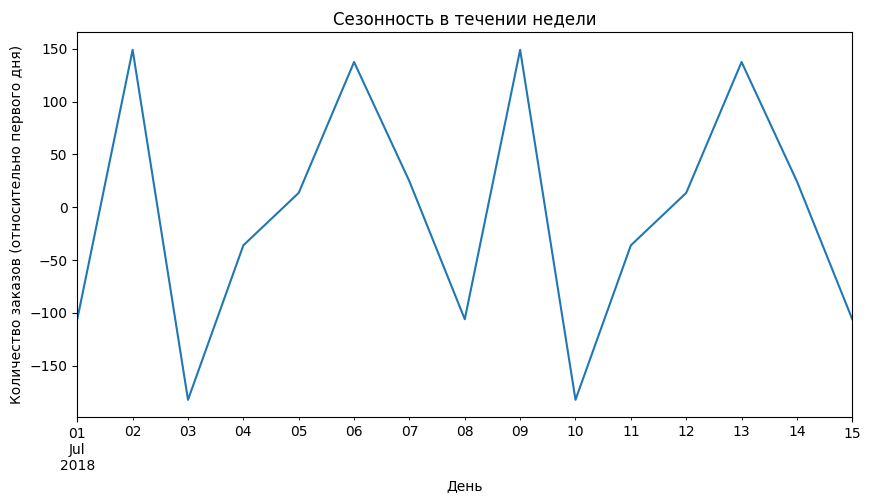

In [21]:
plt.figure(figsize=(10, 5))
decomposed_data.seasonal['2018-07-01':'2018-07-15'].plot(title='Сезонность в течении недели')
plt.xlabel('День')
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

Ситуация очень похожа. Больше всего поездок наблюдается в понедельник и пятницу, а меньше всего во вторник и в выходные. Скорее всего найденная сезонность не случайна. Посмотрим как меняется количество заказов в течении дня.

In [22]:
decomposed = seasonal_decompose(data)

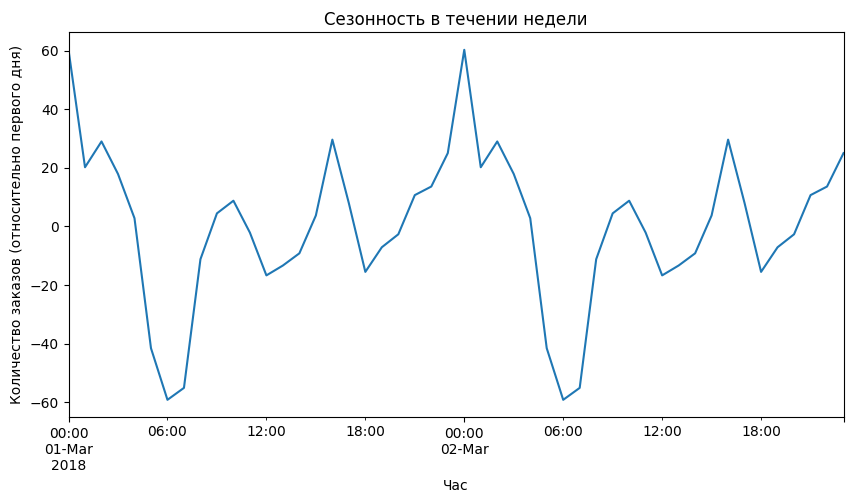

In [23]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(title='Сезонность в течении недели')
plt.xlabel('Час')
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

Можем увидеть, что максимальный спрос приходится примерно на 00:00, а минимальный на 06:00. Так же в течении дня наблюдается несколько локальных максимумов в примерно 10:00 и 16:00.

**Вывод**

В данном разделе мы построили и проанализировали графики временного ряда. В результате установили, что:
- с начала марта по конец августа количество заказов росло от месяца к месяцу,
- больше всего поездок наблюдается в понедельник и пятницу, а меньше всего во вторник и выходные,
- максимальный спрос в течении суток приходится примерно на 00:00, а минимальный на 06:00.

Переходим к обучению моделей.

## Обучение

Разделим данные на выборки. Тестовая выборка должна быть размером 10% от исходных данных. Валидационную выборку отделять не будем, так как в дальнейшем для обучения моделей будем использовать GridSearchCV.

In [23]:
features = new_data.drop('num_orders', axis=1)
target = new_data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

print('Размер тренировочной выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер тренировочной выборки: (3952, 28)
Размер тестовой выборки: (440, 28)


Преждем чем обучать модели создадим объект TimeSeriesSplit. Это специальный метод разбиения данных на выборки для временных рядов. С помощью него мы сможем использовать кросс-валидацию, но в отличие от стандартной кросс-валидации, где данные случайно перемешиваются, TimeSeriesSplit сохраняет хронологическую последовательность временных данных. Исходную выборку разобьем на 5 фолдов.

In [24]:
tscv = TimeSeriesSplit(n_splits=4)

Далее можем переходить к обучению моделей. В данном проекте обучим три модели: RandomForest, CatBoost, LightGBM. Среди них нам предстоит выбрать модель с наилучшим показателем метрики *RMSE*.

### RandomForest

Обучим модеь случайного леса.

In [25]:
%%time


model_rf = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators': range (50, 201, 50),
              'max_depth': range (4, 13, 2)}
scores_rf = GridSearchCV(model_rf, 
                         parameters, 
                         scoring='neg_root_mean_squared_error', 
                         cv=tscv, 
                         n_jobs=-1)
scores_rf.fit(features_train, target_train)
rmse_rf = np.round(np.abs(scores_rf.best_score_), 1)

print('Значения гиперпараметров лучшей модели:', scores_rf.best_params_)
print('Лучшая оценка качества модели:', rmse_rf)

Значения гиперпараметров лучшей модели: {'max_depth': 12, 'n_estimators': 150}
Лучшая оценка качества модели: 25.8
CPU times: total: 6.19 s
Wall time: 35.7 s


Лучшая модель случайного леса выдаёт значение метрики *RMSE* = 25.8. Значиения гиперпараметров этой модели следующие: max_depth = 12, n_estimators = 150. 

### LightGBM

Обучим модель LightGBM.

In [26]:
%%time

model_lgbm = LGBMRegressor(random_state=12345)
parameters = {'max_depth': range(4, 13, 2) ,
              'n_estimators': range(50, 201, 50),
              'learning_rate': [0.1, 0.15, 0.2],
              'verbose': [0]}
scores_lgbm = GridSearchCV(model_lgbm, 
                           parameters, 
                           scoring='neg_root_mean_squared_error',
                           cv=tscv,
                           n_jobs=-1)
scores_lgbm.fit(features_train, target_train)
rmse_lgbm = np.round(np.abs(scores_lgbm.best_score_), 1)

print('Значения гиперпараметров лучшей модели:', scores_lgbm.best_params_)
print('Лучшая оценка качества модели:', rmse_lgbm)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

Лучшая модель LightGBM выдаёт значение метрики *RMSE* = 25.5. Значиения гиперпараметров этой модели следующие: max_depth = 4, n_estimators = 50, learning_rate = 0.2. 

### CatBoost

Обучим модель CatBoost.

In [27]:
%%time


model_cbr = CatBoostRegressor(random_seed=12345)
parameters  = {'depth': range(4, 13, 4),
               'iterations': range(50, 201, 50), 
               'learning_rate': [0.1, 0.15, 0.2],
               'verbose': [0]}
scores_cbr = GridSearchCV(model_cbr, 
                          parameters, 
                          scoring='neg_root_mean_squared_error', 
                          cv=tscv, 
                          n_jobs=-1)
scores_cbr.fit(features_train, target_train)
rmse_cbr = np.round(np.abs(scores_cbr.best_score_), 1)

print('Значения гиперпараметров лучшей модели:', scores_cbr.best_params_)
print('Лучшая оценка качества модели:', rmse_cbr)

Значения гиперпараметров лучшей модели: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1, 'verbose': 0}
Лучшая оценка качества модели: 25.3
CPU times: total: 2.84 s
Wall time: 13min 58s


Лучшая модель CatBoost выдаёт значение метрики *RMSE* = 25.3. Значиения гиперпараметров этой модели следующие: depth = 4, iterations = 200, learning_rate = 0.1. 

**Вывод**

В данном разделе мы обучили несколько моделей машинного обучения, подобрали оптимальные гиперпараметры и установили, что значение метрики *RMSE* довольно близкие для всех моделей. Для тестирования выберем модель LightGBM, поскольку она обучалась гораздо быстрее, чем CatBoost, а значение *RMSE* у нее ниже чем у RandomForest, с которым она обучалась примерно одинаково по времени. Лучшая модель имеет следующие значения гиперпараметров: max_depth = 4, n_estimators = 50, learning_rate = 0.2. 

Переходим к тестированию выбранной модели.

## Тестирование

Выполним проверку лучшей модели на тестовой выборке.

In [29]:
final_model = LGBMRegressor(max_depth = 4, n_estimators = 50, learning_rate = 0.2, random_state=12345)
final_model.fit(features_train, target_train)
predictions = final_model.predict(features_test)
final_rmse = mean_squared_error(predictions, target_test, squared=False)
print('Итоговое RMSE на тестовой выборке', final_rmse)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 28
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

В результате модель градиентного бустигна LightGBM на тестовой выборке показала значение *RMSE* = 41.3. Это удовлетворяет условию задачи о том, что значение данной метрики должно быть не выше 48. 

Построим график предсказний модели и реальных значений из тестовой выборки. Проанализируем результат предсказания.

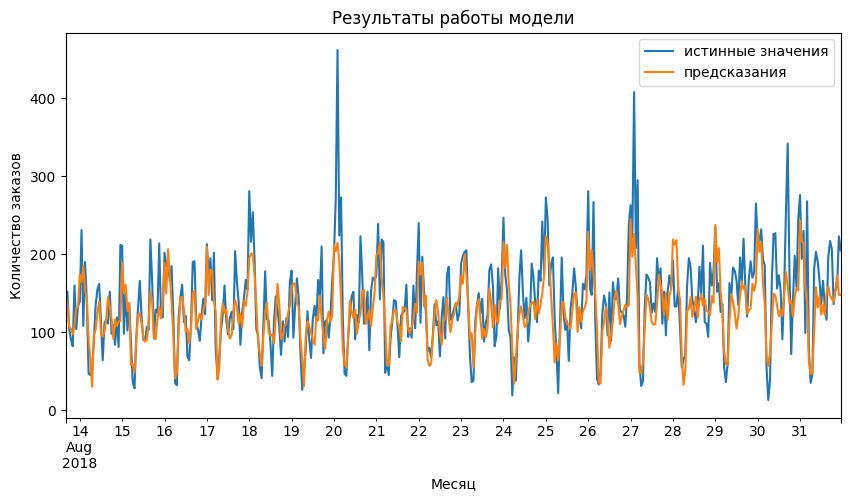

In [32]:
predictions = pd.Series(predictions, index=target_test.index)

plt.figure(figsize=(10, 5))
target_test.plot(label='истинные значения', title='Результаты работы модели')
predictions.plot(label='предсказания')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Можно сказать, что предсказания нашей модели довольно близки к истинным значениям на тесте. Модель неплохо поняла закономерности в данных, и мы можем видить совпадения между графиками в отрезках роста и убывания.

## Общий вывод

В ходе исследования мы провели работу для прогнозирования количества заказов такси за следующий час.


Исследуя данные, мы:
1. Загрузили и изучили данные.
2. Создали функцию для добавления новых признаков.
3. Проанализировали графки трендов и сезонности в данных, чтобы лучше понимать временной ряд. Зафиксировали закомномерности в данных.
4. Провели обучение и подбор гиперпараметров для трех моделей: RandomForest, LightGBM, CatBoost.
5. В качестве лучшей выбрали модель LightGBM со следующими гиперпараметрами: max_depth = 4, n_estimators = 50, learning_rate = 0.2. На валидации модель выдала значение *RMSE* = 25.5.
6. На тестовой выборке лучшая модель показала значение *RMSE* = 41.3. По условию задачи значение метрики *RMSE* должно быть не ниже 48, и мы успешно его выполнили.